We solve the steady advection dominated skew to mesh benchmark problem as described in [links go here] using the various methods encountered in class. The problem entails solving the advection diffusion equation on the unit square:

$$-\kappa \Delta u + \beta\cdot \nabla u = 0  $$

with $\kappa = 10^{-3}$, $\beta = (.5, 1)$ on a square grid with dirichlet boundary condition 

$$u = \begin{cases} 1 & y = 0 \text{ or } x = 0 \text{ and } y < 0.2 \\ 0 & \text{otherwise} \end{cases}   $$ 

Any reasonably good numerical solution to this problem would have to exhibit minimal oscillation, sharp boundary layers on the top and right sides of the domain as well as a sharp boundary separating the advected trivial left-side boundary condition from the non-trivial left-side boundary condition in the unit square.


In [1]:
import nutils as ntl
import numpy as np
import matplotlib.pyplot as plt
import inspect


## Galerkin: what a bad solution might look like

**Weak Form**: $$0 = \int_\Omega \kappa \, N_{A, j}\cdot u_{, j} \,-\, u\, N_{A, k}\beta_k \, dx$$
where $N_i$ is a basis function.

In [27]:
degree = 1 #degree of basis functions
nelems = 30 #number of elements along edge of unit square
etype = 'square'

topo, geom =  ntl.mesh.unitsquare(nelems, etype) #rectilinear([np.linspace(0,1, nx), np.linspace(0,1, ny) ])
ns = ntl.function.Namespace()
ns.x = geom
ns.beta= np.array([0.5, 1.0])
ns.kappa = 1e-3
ns.basis = topo.basis('lagrange', degree = degree)
ns.u = 'basis_i ?dofs_i'


#Dirichlet boundary condition
ns.badbnd = topo.boundary['left'].indicator(topo.boundary['left'][0:int(nelems/5)])

sqr = topo.boundary['bottom'].integral('(u - 1)^2 d:x' @ ns, degree = degree*2)
sqr += topo.boundary['left'].integral( '(u - badbnd)^2 d:x' @ ns, degree = degree*2 )
sqr += topo.boundary['right'].integral( '(u - 0)^2 d:x' @ ns, degree = degree*2 )
sqr += topo.boundary['top'].integral( '(u - 0)^2 d:x' @ ns, degree = degree*2 )
cons = ntl.solver.optimize('dofs', sqr, droptol=1e-15) #this applies the boundary condition to u
'''
print(topo.boundary['left'][0:int(nelems/5)])    
bezier = topo.sample('bezier', 2)
bezier2 = topo.boundary['left'].sample('bezier', 2)
x = bezier2.eval(ns.x[1])
badbnd1 = bezier2.eval(2* topo.boundary['left'].indicator(topo.boundary['left'][0:int(nelems/5)]))
print(badbnd1, x)
plt.plot(x, badbnd1, '*')
''' 

#residual
res = topo.integral( '(kappa basis_i,j u_,j  - u basis_i,n beta_n) d:x' @ ns, degree = degree * 2) 

lhs = ntl.solver.solve_linear('dofs', res, constrain= cons)

bezier = topo.sample('bezier', 2)
x = bezier.eval('x_i' @ ns)
u = bezier.eval('u' @ ns, dofs = lhs)

ntl.export.triplot('ADSM_Gal.png', x, u, tri=bezier.tri, hull=bezier.hull)

optimize > solve > solving 120 dof system to machine precision using direct solver
optimize > solve > solver returned with residual 1e-17
optimize > constrained 120/961 dofs
optimize > optimum value 9.62e-03
solve > solving 841 dof system to machine precision using direct solver
solve > solver returned with residual 6e-17
ADSM_Gal.png


## SUPG

**Weak Form**:
$$0 = \int_\Omega \kappa \, N_{A, j}\, u_{, j} \,-\, u\, N_{A, k}\,\beta_k \, dx + \int_\Omega \tau\, \beta_n N_{A, n} 
( - \kappa\, u_{, mm} + \beta_k\, u_{,k}) \, dx$$

We use $\tau = \frac{h}{2|\beta|}$ in the code below

In [26]:
degree = 1 #degree of basis functions
nelems = 30 #number of elements along edge of unit square
etype = 'square'

topo, geom =  ntl.mesh.unitsquare(nelems, etype) #rectilinear([np.linspace(0,1, nx), np.linspace(0,1, ny) ])
ns = ntl.function.Namespace()
ns.x = geom
ns.beta= np.array([0.5, 1.0])
ns.kappa = 1e-3
ns.basis = topo.basis('lagrange', degree = degree)
ns.u = 'basis_i ?dofs_i'

#element intrinsic time scale
ns.h = np.sqrt(2/nelems**2) #mesh size parameter
ns.betanorm = '(beta_i beta_i)^.5'
ns.tau = 'h / (2 betanorm)'

#dirichlet boundary condition
ns.badbnd = topo.boundary['left'].indicator(topo.boundary['left'][0:int(nelems/5)])
sqr = topo.boundary['bottom'].integral('(u - 1)^2 d:x' @ ns, degree = degree*2)
sqr += topo.boundary['left'].integral( '(u - badbnd)^2 d:x' @ ns, degree = degree*2 )
sqr += topo.boundary['right'].integral( '(u - 0)^2 d:x' @ ns, degree = degree*2 )
sqr += topo.boundary['top'].integral( '(u - 0)^2 d:x' @ ns, degree = degree*2 )
cons = ntl.solver.optimize('dofs', sqr, droptol=1e-15) #this applies the boundary condition to u


#residual
res = topo.integral( '(kappa basis_i,j u_,j  - u basis_i,n beta_n) d:x' @ ns, degree = degree * 2) 
res += topo.integral( 'tau beta_k basis_i,k (-kappa u_,jj + beta_n u_,n)  d:x' @ ns, degree = degree * 2) 

lhs = ntl.solver.solve_linear('dofs', res, constrain= cons)

bezier = topo.sample('bezier', 2)
x = bezier.eval('x_i' @ ns)
u = bezier.eval('u' @ ns, dofs = lhs)


ntl.export.triplot('ADSM_SUPG.png', x, u, tri=bezier.tri, hull=bezier.hull)



#'''

optimize > solve > solving 120 dof system to machine precision using direct solver
optimize > solve > solver returned with residual 1e-17
optimize > constrained 120/961 dofs
optimize > optimum value 9.62e-03
solve > solving 841 dof system to machine precision using direct solver
solve > solver returned with residual 1e-16
ADSM_SUPG.png


## Galerkin/Least squares

In [58]:
#print((beta *beta).sum(0)) #ct.getfullargspec(topo.basis))
#elp(np.dot)#(topo.basis)
help(ntl.export.triplot)
#print(topo.boundary)
#help(bezier.eval)
a = [1 ,2, 3, 4, 5, 8, 6, 7]
print(a[:])

Help on function triplot in module nutils.export:

triplot(name, points, values=None, *, tri=None, hull=None, cmap=None, clim=None, linewidth=0.1, linecolor='k')

[1, 2, 3, 4, 5, 8, 6, 7]


(36, 2)


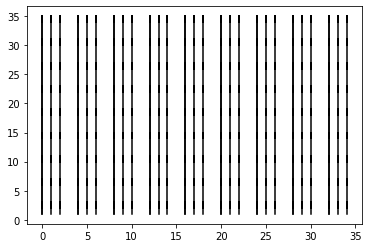

In [16]:
print(bezier.hull.shape)
b = bezier.hull
B0, B1 = np.meshgrid(b[:,0], b[:, 1])

plt.plot(B0, B1, 'k')